In [1]:
import os
import sys

chrome_driver_path = os.path.join("/", 'usr', 'local', 'bin', 'chromedriver')
app_path = os.path.join("/", 'usr', 'local', 'bin', 'chromedriver')
os.environ["PATH"] += os.pathsep + app_path
os.environ["MINIWOB_BASE_URL"] = "file:///Users/a18401417/work//miniwob-plusplus/html/"

In [2]:
from miniwob.environment import MiniWoBEnvironment
from miniwob.action import  MiniWoBCoordClick
from miniwob.screenshot import pil_to_numpy_array

task_name = 'click-button'
base_url = os.environ.get('MINIWOB_BASE_URL')
env = MiniWoBEnvironment(task_name, seeds=[1, 2, 3], num_instances=3, base_url=base_url)
print('BASE URL:', base_url)

BASE URL: file:///Users/a18401417/work//miniwob-plusplus/html/


In [3]:
states = env.reset(record_screenshots=True)

In [4]:
states

[MiniWoBState(utterance: 'Click on the "Ok" button.'),
 MiniWoBState(utterance: 'Click on the "ok" button.'),
 MiniWoBState(utterance: 'Click on the "no" button.')]

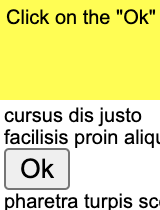

In [9]:
states[0].screenshot

In [10]:
img = pil_to_numpy_array(states[0].screenshot)
img.shape

(210, 160, 3)

In [11]:
states[0].dom.visualize()

"- [1] body @ (0, 0) classes=[NO_CLASS] children=1\n  |- [2] div @ (0, 0) classes=[NO_CLASS] children=1\n     |- [3] div @ (0, 50) classes=[NO_CLASS] children=6\n        |- [4] div @ (2, 52) text='cursus dis justo' classes=[NO_CLASS]\n        |- [5] div @ (2, 63) text='facilisis proin aliq...' classes=[NO_CLASS]\n        |- [6] button @ (2, 74) text='Ok' classes=[NO_CLASS]\n        |- [7] div @ (2, 95) text='pharetra turpis scel...' classes=[NO_CLASS]\n        |- [8] div @ (2, 106) text='rutrum lectus adipis...' classes=[NO_CLASS]\n        |- [9] div @ (2, 117) text='pretium, aliquet ege...' classes=[NO_CLASS]"

In [12]:
states[0].tokens

['Click', 'on', 'the', '"', 'Ok', '"', 'button', '.']

In [13]:
env.close()

# Gym miniwob wrapper

In [24]:
import gym
import torch
import numpy as np

from miniwob.action import MiniWoBElementClick, MiniWoBCoordClick
from transformers import BertTokenizer, BertModel, BertConfig


class MiniWobClickButtonWrapper(gym.Wrapper):
    
    def __init__(self, env):      
        super().__init__(env)
        self.env = env
        bert_model = 'bert-base-cased'
        self.tokenizer = BertTokenizer.from_pretrained(bert_model)
        
        self.observation_space = gym.spaces.Dict({"goal_state": gym.spaces.Box(0, 
                                                                              self.tokenizer.vocab_size, (8, ),
                                                                              dtype=np.int64), 
                                                 "state": gym.spaces.Box(0, 255, (210, 160, 3), dtype=np.uint8)})
        

        self.h, self.w = 210, 160
        self.grid_step = 10
        n_actions = int(self.h/self.grid_step+1) * int(self.w/self.grid_step+1)
        self.action_space = gym.spaces.Discrete(n_actions)
        
    def _ob_to_token(self, ob):
        max_length = 8
        if ob is None:
            return torch.zeros(1, max_length)
        else: 
            return self.tokenizer(ob.tokens,  
                                  padding='max_length', 
                                  max_length = max_length, truncation=True,          
                                  return_tensors="pt",
                                  is_split_into_words=True)['input_ids']
            
    def _ob_to_image(self, ob):
        if ob is None:
            return torch.zeros(1, self.h, self.w, 3)
        else:
            return torch.tensor(pil_to_numpy_array(ob.screenshot)).unsqueeze(0)
        
    
    def _to_miniwob_actions(self, actions):
        
        n_x = int(self.w/self.grid_step + 1)        
        actions = actions.squeeze()
        miniwob_actions = []
        
        for i in range(self.num_instances):
            if self.instances[i].get_metadata()['done']:
                miniwob_actions.append(None)
            else:
                k = actions[i].item()
                x, y = k%n_x * self.grid_step, int(k/n_x) * self.grid_step
                miniwob_actions.append(MiniWoBCoordClick(x, y))
        return miniwob_actions
        
    
    def observation(self, obs):
            
        goals = torch.cat([self._ob_to_token(ob) for ob in obs], dim=0)
        imgs = torch.cat([self._ob_to_image(ob) for ob in obs], dim=0)
        doms = ["" for ob in obs] # ob.dom.visualize()
        return {'state': imgs, 'dom': doms, 'goal_state': goals}
    
    def reset(self):
        return self.observation(self.env.reset(record_screenshots=True))
    
            
    
    def step(self, actions):
        
        miniwob_actions = self._to_miniwob_actions(actions)
        obs, rewards, dones, infos = self.env.step(miniwob_actions)        
        obs = self.observation(obs)
        
        for instance in self.env.instances:
            if instance.get_metadata()['done']:
                instance.begin_task()
        
        return obs, torch.tensor([rewards]).T, torch.tensor([dones]).T, infos['n']
        
class EpisodeInfoWrapper(gym.Wrapper):
    
    def __init__(self, env, n):
        super(EpisodeInfoWrapper, self).__init__(env)
        self.episode_reward = np.zeros(n)
        self.episode_steps = np.zeros(n)
        self.n = n

    def reset(self):
        self.episode_reward = np.zeros(self.n)
        self.episode_steps = np.zeros(self.n)
        return self.env.reset()

    def step(self, actions):
        states, rewards, dones, infos = self.env.step(actions)
        
        for i, done in enumerate(dones):
            if done:
                self.episode_reward[i] = rewards[i]
                self.episode_steps[i] += 1
                infos[i]['episode'] = {'r': self.episode_reward[i], 'steps': self.episode_steps[i]}
                
        return states, rewards, dones, infos

In [25]:
def get_envs(n, **kwargs):
    env = MiniWoBEnvironment(task_name, seeds=range(n), num_instances=n, base_url=base_url, **kwargs)
    env = MiniWobClickButtonWrapper(env)
    return EpisodeInfoWrapper(env, n)

# Bert encoder

In [26]:
from transformers import BertTokenizer, BertModel, BertConfig
from torch import nn
import torch

class BertEncoder(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        bert_model = 'bert-base-cased'
        self.bert_encoder = BertModel.from_pretrained(bert_model)
        self.embed_dim = 768
        output_size = 100
        self.lstm = nn.LSTM(input_size=self.embed_dim, 
                            hidden_size=output_size, 
                            num_layers=2)
        self.hidden_size = 32
        in_size = output_size
        out_size = self.hidden_size
        self.fc = nn.Sequential(nn.Linear(in_size, out_size), nn.ReLU())
        self.output_size = out_size
   
    def forward(self, input_ids):
        """
        Encode batch of tokens
        
        """
        with torch.no_grad():
            embeds = self.bert_encoder(input_ids.long()).last_hidden_state
        embeds = embeds.permute([1, 0, 2])
            
        output, _ = self.lstm(embeds)
        return self.fc(output[-1])

In [27]:
import torchvision.models as zoo_models

class ResNetEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = zoo_models.resnet34(pretrained=True)
        self.output_size = 32
        self.resnet = nn.Sequential(*list(resnet.children())[:-1])
        in_size, out_size = 512, self.output_size
        self.fc = nn.Sequential(nn.Linear(in_size, out_size), nn.ReLU())

    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        with torch.no_grad():
            encoded = self.resnet(x).reshape(x.shape[0], -1)
        return self.fc(encoded)

In [28]:
class Permute(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.dims = args

    def forward(self, x):
        return x.permute(self.dims)

class SimpleCNN(nn.Module):
    def __init__(self, h, w, conf):
        super().__init__()
        conv_layers = [Permute(0, 3, 1, 2)]
        cnn_output_h, cnn_output_w = h, w
        cur_channels = 3
        conv_params = zip(
            conf['n_channels'],
            conf['kernel_sizes'],
            conf['max_pools'] if conf.get('max_pools', False) else [1] * len(conf['n_channels']),
            conf['strides'] if conf.get('strides', False) else [1] * len(conf['n_channels'])
        )
        for n_channels, kernel_size, max_pool, stride in conv_params:
            conv_layers.append(nn.Conv2d(cur_channels, n_channels, kernel_size, stride))
            conv_layers.append(nn.ReLU(inplace=True))
            cnn_output_h += -1 * kernel_size + stride
            cnn_output_w += -1 * kernel_size + stride
            cnn_output_h //= stride
            cnn_output_w //= stride
            cur_channels = n_channels
            if max_pool > 1:
                conv_layers.append(nn.MaxPool2d(max_pool, max_pool))
                cnn_output_h //= max_pool
                cnn_output_w //= max_pool
        self.conv_net = nn.Sequential(*conv_layers)
        output_size = cur_channels * cnn_output_h * cnn_output_w

        hidden_layers_sizes = list(conf.get('hidden_layers_sizes', []))
        if hidden_layers_sizes:
            fc_layers = []
            layers_size = [output_size] + hidden_layers_sizes
            for size_in, size_out in zip(layers_size[:-1], layers_size[1:]):
                fc_layers.append(nn.Linear(size_in, size_out))
                fc_layers.append(nn.ReLU())
            self.fc = nn.Sequential(*fc_layers)
            output_size = layers_size[-1]
        else:
            self.fc = None

        self.output_size = output_size

    def forward(self, x):
        res = self.conv_net(x.float() / 255.).reshape(x.shape[0], -1)
        if self.fc is not None:
            res = self.fc(res)
        return res

# Init encoders

In [41]:
from rllr.models.encoders import GoalStateEncoder # , SimpleCNN

conf = {
    "n_channels": [32, 32, 32, 32, 32, 32],
    "kernel_sizes": [16, 8, 4, 4, 4, 4],
    "strides": [4, 2, 1, 1, 1, 1],
    "hidden_layers_sizes": [128]
}

state_encoder = SimpleCNN(h=210, w=160, conf=conf)
goal_encoder = BertEncoder()
encoder = GoalStateEncoder(state_encoder, goal_encoder)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Train agent

In [42]:
n_instances = 8
envs = get_envs(n_instances, headless=True)

In [43]:
from rllr.algo import PPO
from rllr.models.ppo import ActorCriticNetwork

hidden_size = 32
policy = ActorCriticNetwork(envs.action_space, encoder, encoder, hidden_size, hidden_size)

agent_conf = {
        "clip_param": 0.2,
        "ppo_epoch": 4,
        "num_mini_batch": 4,
        "value_loss_coef": 0.5,
        "entropy_coef": 0.01,
        "lr": 0.001,
        "eps": 1e-5,
        "max_grad_norm": 0.5,
}


agent = PPO(policy, **agent_conf)

In [ ]:
from rllr.utils.training import train_ppo

train_conf = {
    "agent.lr": 0.001,
    "agent.device": "cpu",
    "agent.gamma": 0.99,
    "agent.gae_lambda": 0.95,
    "training.n_env_steps": 100000,
    "training.n_steps": 100,
    "training.n_processes": n_instances,
    "training.verbose": 5,
    "outputs.path": "minigrid_worker.p"
}


train_ppo(envs, agent, train_conf)

  0%|          | 0/125 [00:00<?, ?it/s]WARNING:root:Cannot call CoordClick(coords: (150, 40)) on instance 3, which is already done


Updates 0, num timesteps 800, FPS 3 
Last 10 training episodes: mean/median reward -0.54/-1.00, min/max reward -1.00/0.84
dist_entropy 5.92, value_loss 0.13, action_loss -0.01


  4%|▍         | 5/125 [18:04<7:10:06, 215.05s/it]

Updates 5, num timesteps 4800, FPS 3 
Last 10 training episodes: mean/median reward -0.82/-1.00, min/max reward -1.00/0.82
dist_entropy 5.87, value_loss 0.08, action_loss -0.01


  8%|▊         | 10/125 [36:07<6:58:12, 218.19s/it]WARNING:root:Cannot call CoordClick(coords: (150, 0)) on instance 3, which is already done


Updates 10, num timesteps 8800, FPS 3 
Last 10 training episodes: mean/median reward -0.81/-1.00, min/max reward -1.00/0.93
dist_entropy 5.73, value_loss 0.07, action_loss -0.02


 12%|█▏        | 15/125 [55:23<6:54:08, 225.90s/it]

Updates 15, num timesteps 12800, FPS 3 
Last 10 training episodes: mean/median reward -0.82/-1.00, min/max reward -1.00/0.76
dist_entropy 5.53, value_loss 0.13, action_loss -0.02


 16%|█▌        | 20/125 [1:13:38<6:27:24, 221.37s/it]

Updates 20, num timesteps 16800, FPS 3 
Last 10 training episodes: mean/median reward -0.41/-1.00, min/max reward -1.00/0.74
dist_entropy 5.33, value_loss 0.12, action_loss -0.02


 20%|██        | 25/125 [1:31:58<6:06:59, 220.20s/it]WARNING:root:Cannot call CoordClick(coords: (20, 150)) on instance 0, which is already done


Updates 25, num timesteps 20800, FPS 3 
Last 10 training episodes: mean/median reward 0.12/0.81, min/max reward -1.00/0.92
dist_entropy 5.19, value_loss 0.15, action_loss -0.02


 24%|██▍       | 30/125 [1:50:28<5:51:23, 221.93s/it]

Updates 30, num timesteps 24800, FPS 3 
Last 10 training episodes: mean/median reward -0.09/0.19, min/max reward -1.00/0.85
dist_entropy 4.86, value_loss 0.17, action_loss -0.02


 28%|██▊       | 35/125 [2:09:01<5:35:56, 223.97s/it]WARNING:root:Cannot call CoordClick(coords: (80, 180)) on instance 5, which is already done


Updates 35, num timesteps 28800, FPS 3 
Last 10 training episodes: mean/median reward -0.18/-0.21, min/max reward -1.00/0.76
dist_entropy 4.72, value_loss 0.19, action_loss -0.02


 32%|███▏      | 40/125 [2:27:13<5:13:06, 221.02s/it]WARNING:root:Cannot call CoordClick(coords: (60, 70)) on instance 6, which is already done


Updates 40, num timesteps 32800, FPS 3 
Last 10 training episodes: mean/median reward -0.02/0.48, min/max reward -1.00/0.93
dist_entropy 4.53, value_loss 0.20, action_loss -0.02


 35%|███▌      | 44/125 [2:42:17<5:03:08, 224.55s/it]